In [29]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib
import torch

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [30]:
# run the HPC_Pre_Process.py and HPC_Post_Process.py first

data1 = torch.load("/Users/xunan/Downloads/Sigma_estimated.pt", map_location="cpu")
print(type(data1))
print(data1.keys() if isinstance(data1, dict) else data1.shape)

data2 = torch.load("/Users/xunan/Downloads/R_solution.pt", map_location="cpu")
print(type(data2))
print(data2.keys() if isinstance(data2, dict) else data2.shape)


<class 'dict'>
dict_keys(['Sb0', 'Sqs', 'qs', 'theta1', 'theta2', 'thetas', 'weights', 'mask', 'lin2idx', 'std_vector', 'sigma'])
<class 'dict'>
dict_keys(['mask', 'lin2idx', 'lambdas', 'history'])


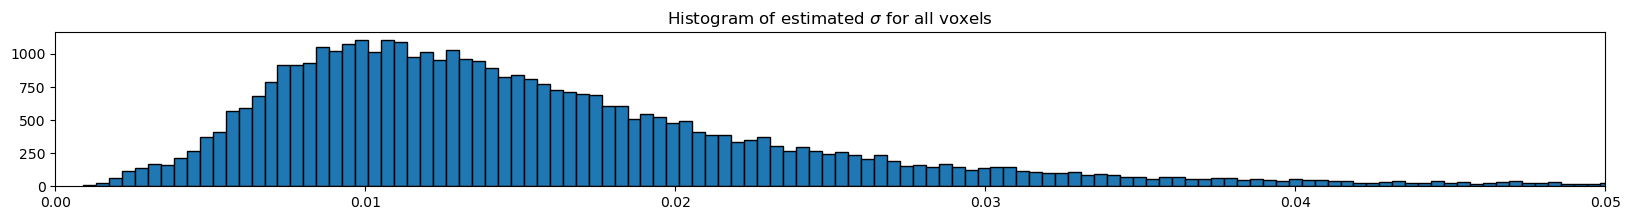

In [31]:
plt.figure(figsize = (20, 2))
plt.hist(data1['std_vector'], bins = 500, edgecolor = 'black')
plt.title(r'Histogram of estimated $\sigma$ for all voxels')
plt.xlim((0, 0.05))
plt.show()


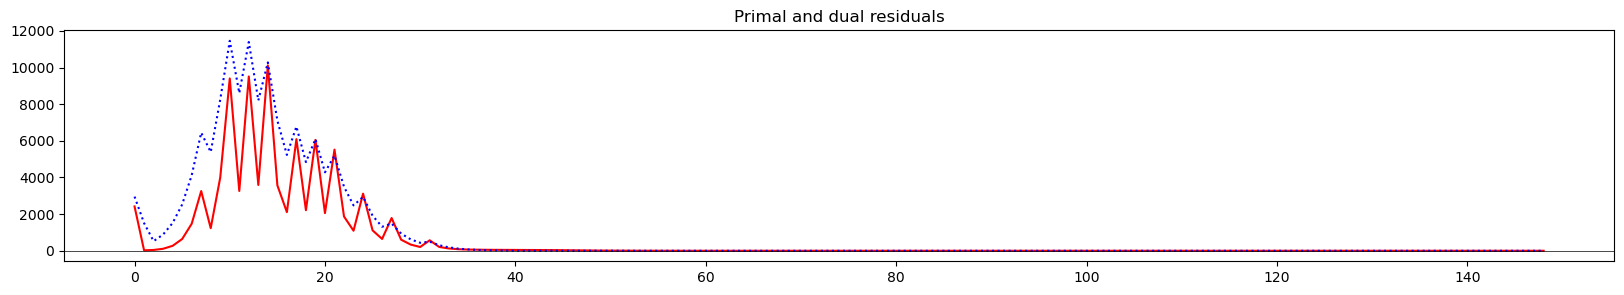

In [32]:
plt.figure(figsize = (20, 3))
plt.plot(data2['history'][1][:], '-', color = 'red', label = 'primal')
plt.plot(data2['history'][2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Primal and dual residuals')
# plt.xlim((0, 50))
plt.show()

In [33]:
f_hat = das.f_thetas_hat(   data2['lambdas'].numpy(), 
                            bf.kernel(  data1['qs'].numpy(), 
                                        data1['thetas'].numpy()), 
                            data1['weights'].numpy(), 
                            1/np.sum(data1['weights'].numpy())*np.ones((torch.sum(data2['mask']).numpy(), data1['thetas'].numpy().shape[0])), 
                            normalize = True)

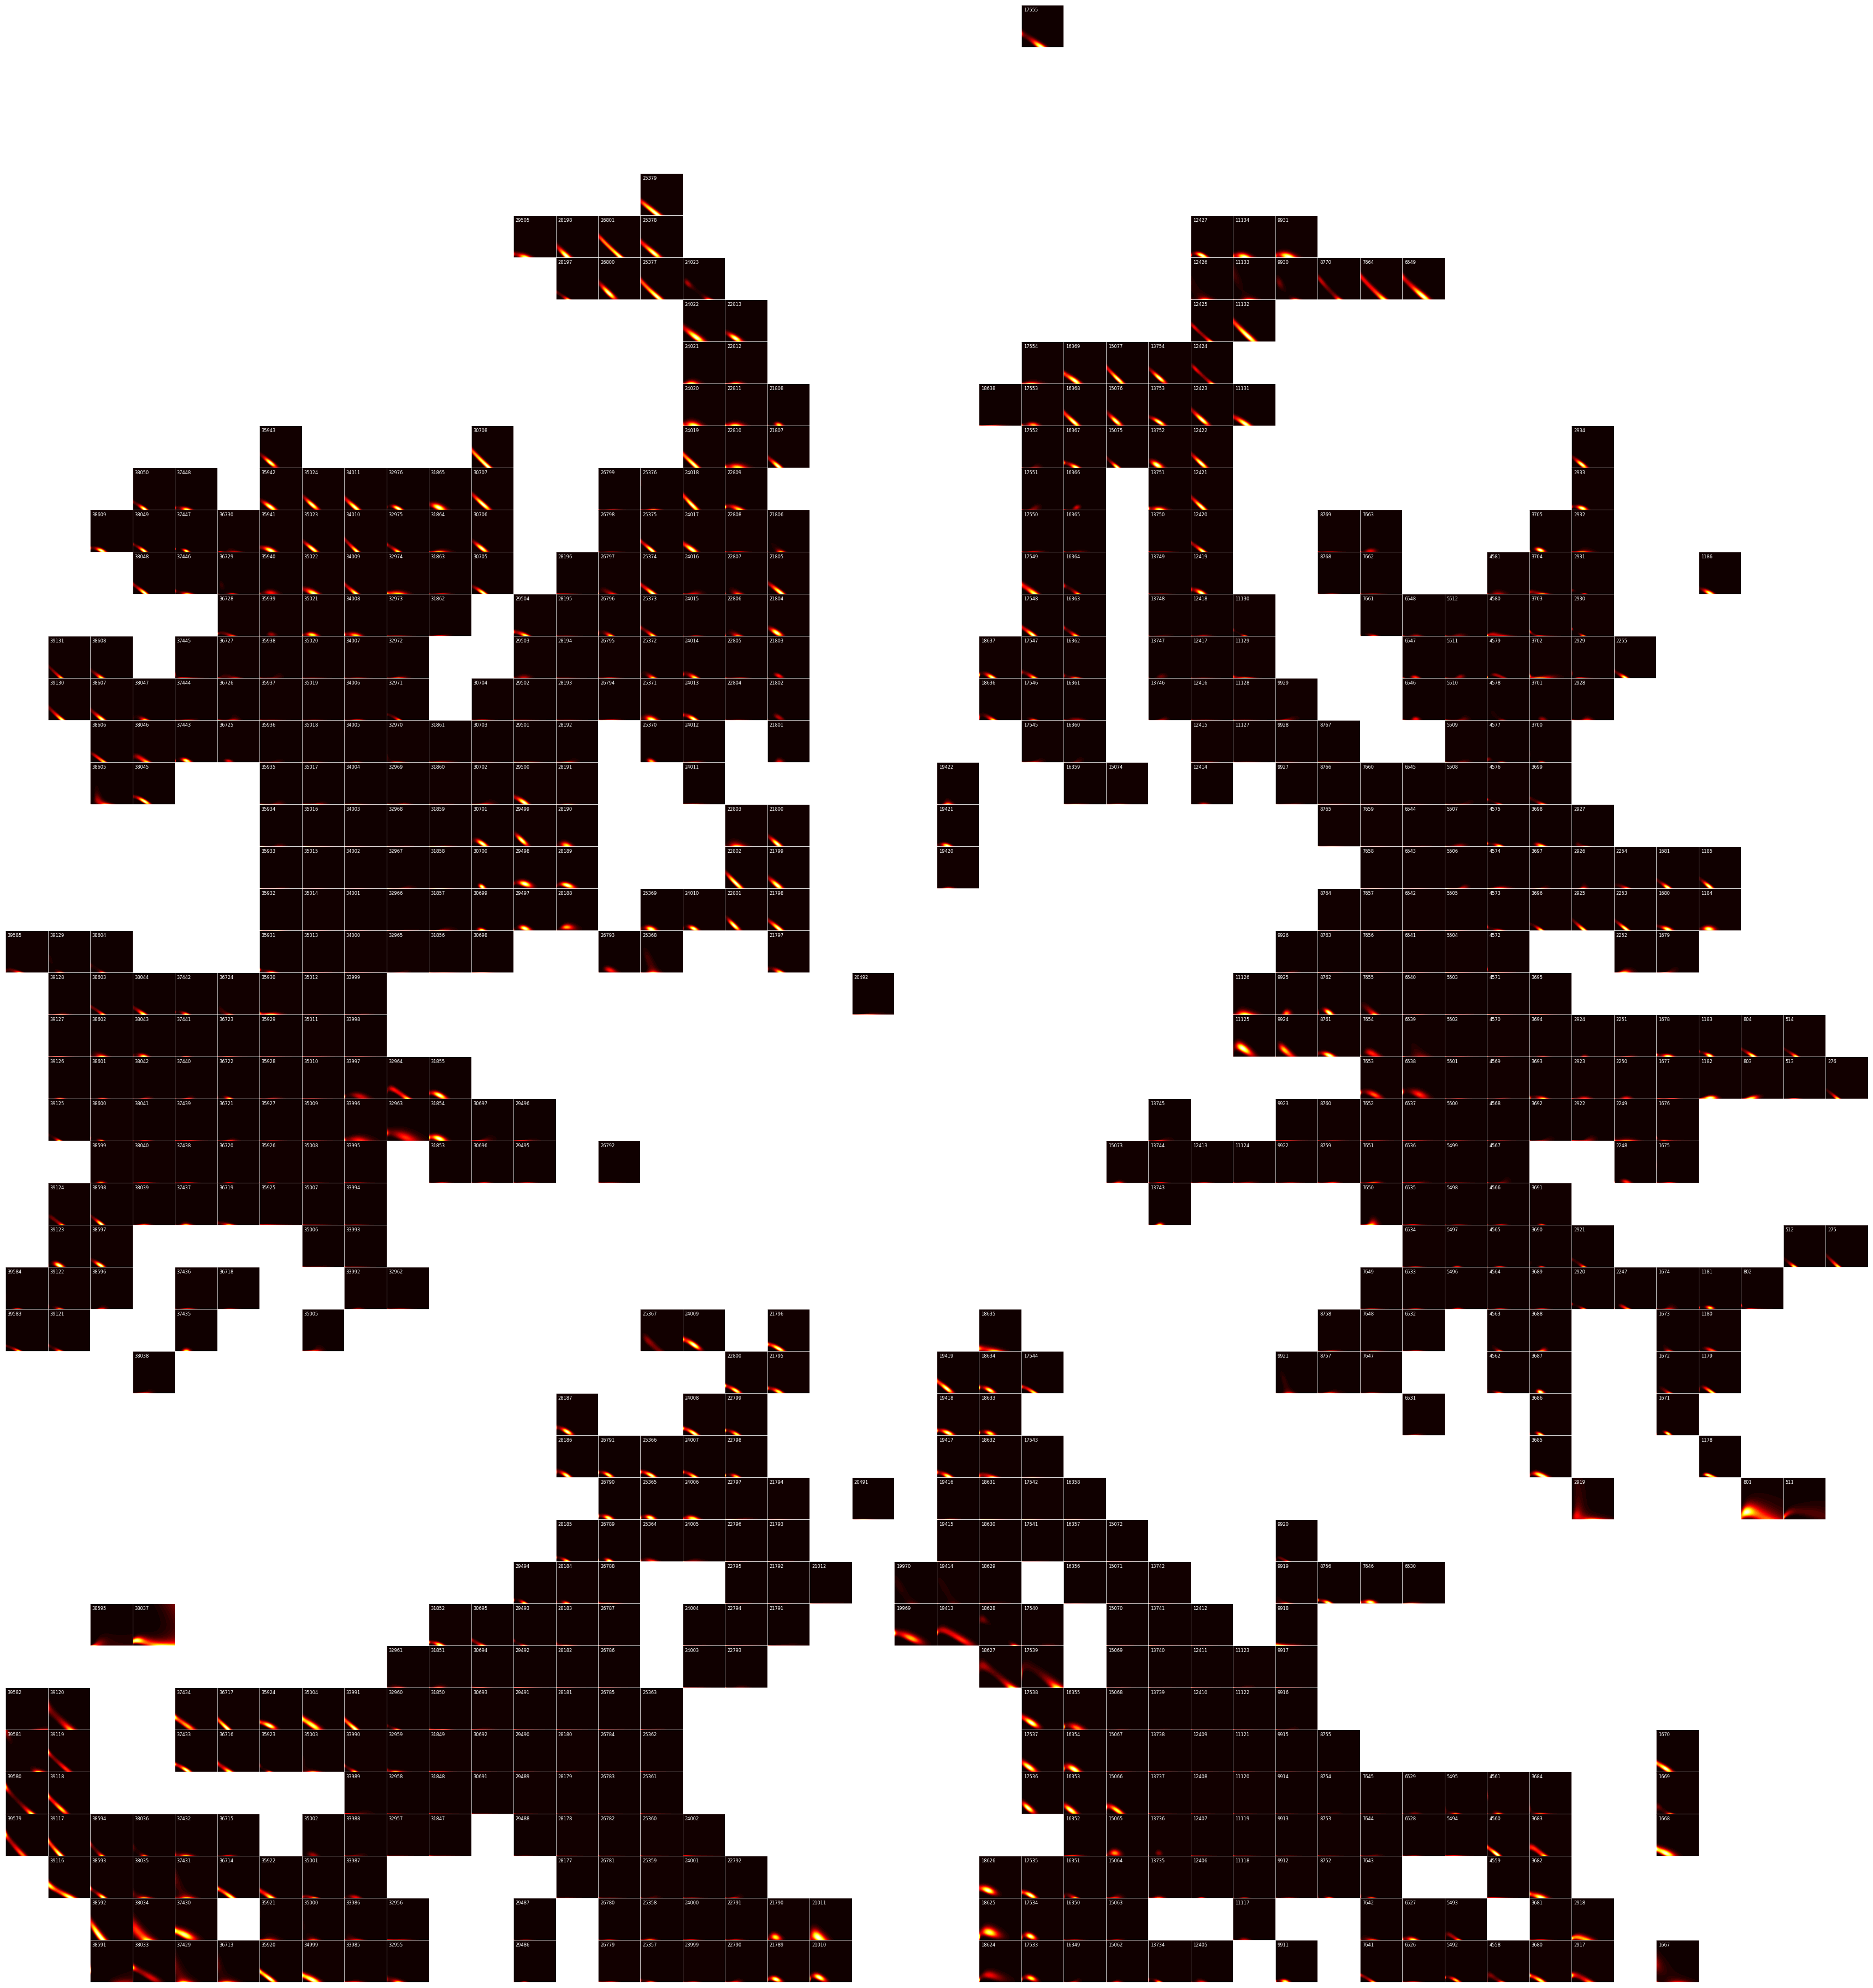

In [34]:
bf.contourf_mask(   data1['theta1'].numpy(), 
                    data1['theta2'].numpy(), 
                    f_hat, 
                    data2['lin2idx'].numpy(), 
                    axis = 1, slice = 31)

In [35]:
# This is used to identify the crashed voxels
# Sometimes, the voxel still doing Newton update is a potential crashed voxel
crashed_lin = np.where(data2['history'][4][:, -1] >= 1)
crashed_idx = np.where(np.isin(data2['lin2idx'], crashed_lin))
print(crashed_lin)
print(crashed_idx)
print(len(crashed_lin[0]))

(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
0


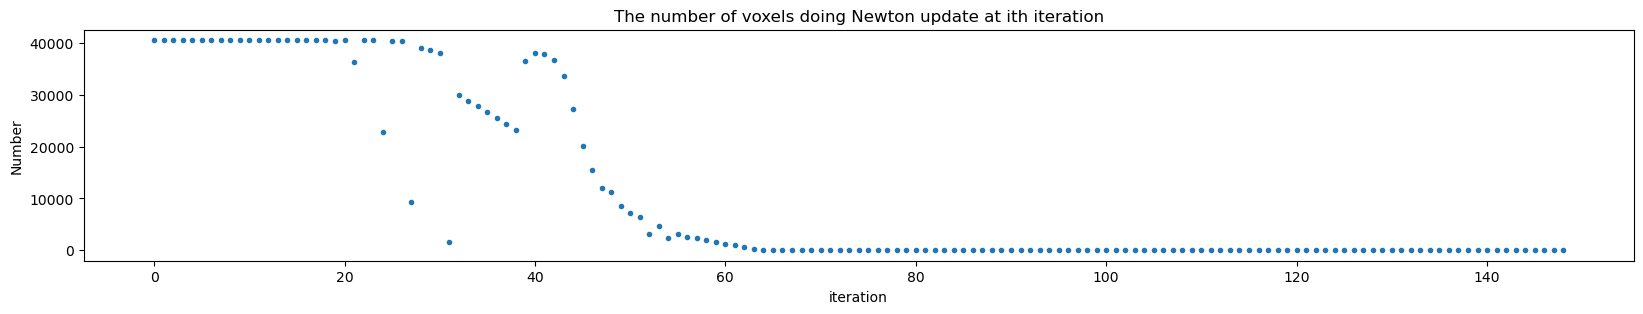

In [36]:
plt.figure(figsize = (20, 3))
plt.plot(np.sum(data2['history'][4][:, :].numpy(), axis = 0), '.')
plt.xlabel('iteration')
plt.ylabel('Number')
plt.title(r'The number of voxels doing Newton update at ith iteration')
plt.show()

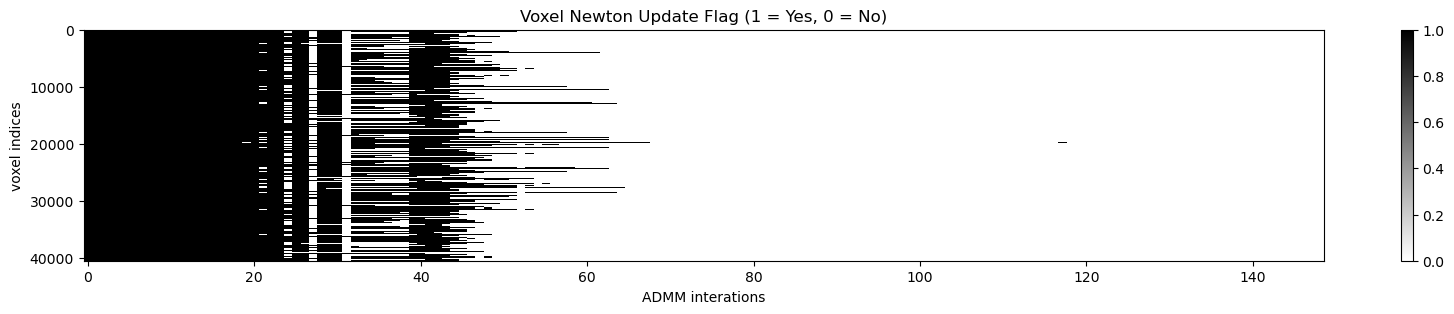

Number of voxels have not converged at the last step: tensor(0)


In [37]:
plt.figure(figsize=(20, 3))
plt.imshow(data2['history'][4][:, :], cmap='gray_r', aspect='auto', interpolation='none')
plt.colorbar()
plt.title('Voxel Newton Update Flag (1 = Yes, 0 = No)')
plt.xlabel('ADMM interations')
plt.ylabel('voxel indices')
plt.show()
print('Number of voxels have not converged at the last step:', torch.sum(data2['history'][4][:, -1] == True))

In [38]:
thetas, weights = bf.Cartesian(data1['theta1'].numpy(), data1['theta2'].numpy())
diff = np.linalg.norm(bf.get_Sqs(bf.kernel(data1['qs'].numpy(), data1['thetas'].numpy()), weights, f_hat) - 
                      data1['Sqs'].numpy()[data2['mask'], :], axis = 1)
print(np.mean(diff**2))

0.009743071631660351


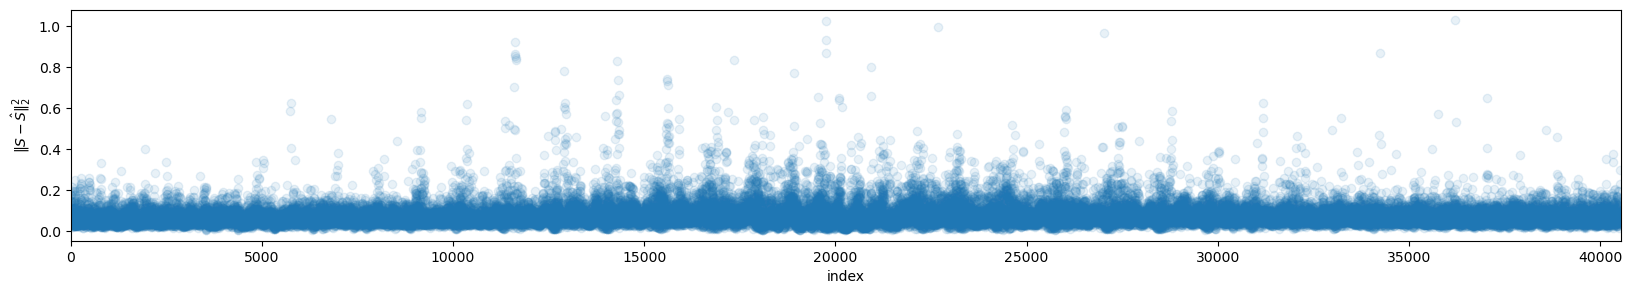

In [39]:
plt.figure(figsize=(20, 3))
plt.plot(diff, 'o', alpha = 0.1)
plt.xlim((0, np.sum(data2['mask'].numpy())))
plt.xlabel('index')
plt.ylabel(r'$\|S - \hat{S}\|_2^2$')
plt.plot(crashed_lin[0], diff[crashed_lin], '.', color = 'red')
# plt.ylim((0, 2))
plt.show()

In [40]:
# which voxels have large diff
np.where(diff >= 1)

(array([19740, 36211]),)

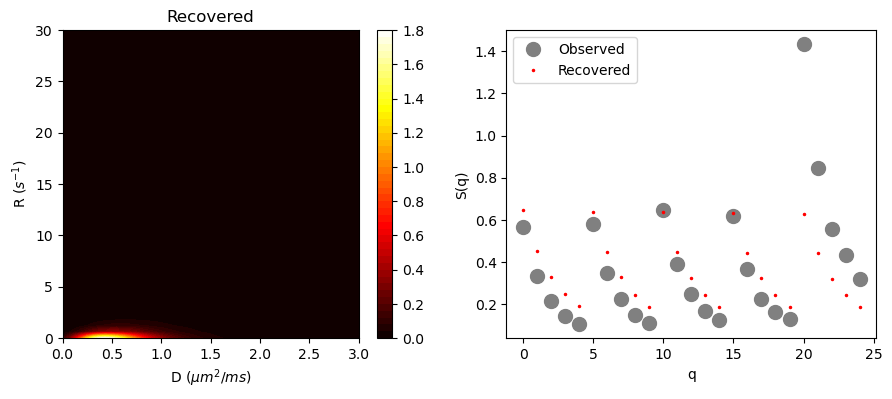

In [ ]:
bf.contourf_compare(data1['theta1'].numpy(), 
                    data1['theta2'].numpy(), 
                    f_hat[19740].ravel(), 
                    data1['qs'].numpy(),    
                    data1['Sqs'].numpy()[data2['mask'], :][19740].ravel())